In [1]:
import wandb
import torch
import yaml
from ecallisto_model import (
    ResNet,
)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm
import os
import pandas as pd
from ecallisto_dataset import (
    EcallistoDatasetBinary,
    custom_resize,
    remove_background,
)


/home/vincenzo/miniconda3/envs/flaresense-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_reference = "vincenzo-timmel/FlareSense-v2/best_model:v324"
CONFIG_PATH = "configs/t999.yml"

In [3]:
api = wandb.Api()
artifact = api.artifact(checkpoint_reference)
artifact_dir = artifact.download()

wandb: Downloading large artifact best_model:v324, 128.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.9


In [4]:
with open(CONFIG_PATH, "r") as file:
    config = yaml.safe_load(file)

In [6]:
def load_model(checkpoint_path, config, device):
    # Initialize the model
    model = ResNet(
        1,
        resnet_type=config["model"]["model_type"],
        optimizer_name="adam",
        learning_rate=1000,
    )

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])

    return model

model = load_model(artifact.file(), config, "cpu")

In [7]:
# Transforms
resize_func = Compose(
    [
        lambda x: custom_resize(x, tuple(config["model"]["input_size"])),
    ]
)


from datasets import DatasetDict, load_dataset

def prepare_datasets(config):
    ds_train = load_dataset(config["data"]["train_path"], split="train")
    ds_valid = load_dataset(config["data"]["val_path"], split="validation")
    ds_test = load_dataset(config["data"]["test_path"], split="test")

    dd = DatasetDict()
    dd["train"] = ds_train
    dd["test"] = ds_test
    dd["validation"] = ds_valid
    return dd


def prepare_dataloaders(ds_train, ds_valid, ds_test, batch_size):
    train_dataloader = DataLoader(
        ds_train, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    val_dataloader = DataLoader(
        ds_valid, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    test_dataloader = DataLoader(
        ds_test, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    return train_dataloader, val_dataloader, test_dataloader

In [8]:
dd = prepare_datasets(config)

Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vincenzo/.cache/huggingface/datasets/i4ds___radio-sunburst-ecallisto-paths-df-v2/default/0.0.0/e60a5f8915c74aa11ef8c179c7776c2946f10f2a (last modified on Fri May 31 12:44:50 2024).
Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vincenzo/.cache/huggingface/datasets/i4ds___radio-sunburst-ecallisto-paths-df-v2/default/0.0.0/e60a5f8915c74aa11ef8c179c7776c2946f10f2a (last modified on Fri May 31 12:44:50 2024).
Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vincenzo/.cache/huggingface/data

In [30]:
t_dl, val_dl, test_dl = prepare_dataloaders(
    EcallistoDatasetBinary(dd["train"], resize_func=resize_func, normalization_transform=remove_background),
    EcallistoDatasetBinary(dd["validation"], resize_func=resize_func, normalization_transform=remove_background),
    EcallistoDatasetBinary(dd["test"], resize_func=resize_func, normalization_transform=remove_background),
    32
)

In [45]:
dd['train'][0]

{'file_path': '/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-COHOE_63/0/2023-04-01_23-02-00.parquet',
 'label': False,
 'antenna': 'ALASKA-COHOE_63',
 'datetime': Timestamp('2023-04-01 23:02:00')}

In [102]:
def extract_Features(model, dataloader, device):
    model.eval()
    model.to(device)
    features_list = []

    # Dictionary to store the features
    features_dict = {}
    meta_data = {'label': [], 'antenna': [], 'datetime': []}

    # Define a hook function to capture the features
    def hook_fn(module, input, output):
        features_dict['features'] = output

    # Register the hook on the avgpool layer
    hook_handle = model.resnet.avgpool.register_forward_hook(hook_fn)

    with torch.no_grad():
        for inputs, labels, antennas, datetimes in tqdm(dataloader):
            inputs = inputs.to(device)
            _ = model(inputs)  # Forward pass
            features = features_dict['features']
            features = torch.flatten(features, 1)
            features_list.append(features.cpu())
            meta_data['label'].extend(labels.cpu().numpy())
            meta_data['antenna'].extend(list(antennas))
            meta_data['datetime'].extend(list(datetimes))
            if len(features_list) > 50:
                break

    # Remove the hook
    hook_handle.remove()

    return features_list, meta_data

In [103]:
features_list, meta_data = extract_Features(model, test_dl, "cpu")

  5%|▌         | 50/955 [00:36<10:59,  1.37it/s]


In [142]:
import numpy as np
# Convert list of tensors to a single tensor
features_tensor = torch.cat(features_list, dim=0)

# Convert tensors to NumPy arrays
features_np = features_tensor.numpy()
labels_np = np.array(meta_data['label'])

In [143]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=2, linkage='complete')
cluster_labels = agglomerative.fit_predict(features_np)


In [148]:
from sklearn.manifold import TSNE

# Standardize features before applying t-SNE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_np)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)
features_2d = tsne.fit_transform(features_scaled)

/home/vincenzo/miniconda3/envs/flaresense-v2/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


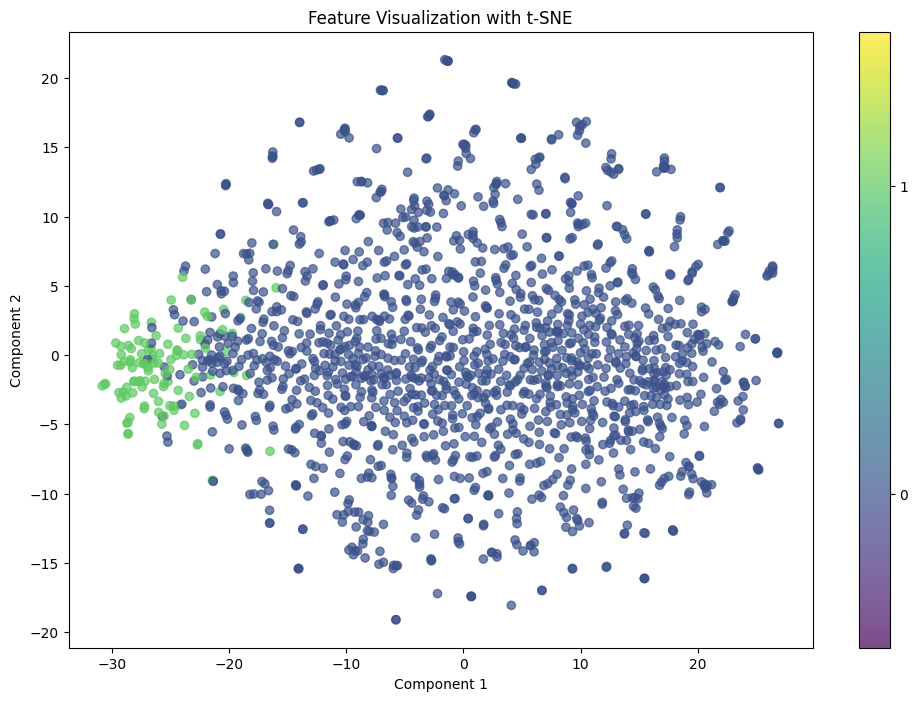

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Create a colormap
num_classes = len(np.unique(labels_np))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    features_2d[:, 0], features_2d[:, 1],
    c=labels_np,
    alpha=0.7
)
plt.colorbar(scatter, ticks=range(num_classes))
plt.clim(-0.5, num_classes - 0.5)
plt.title('Feature Visualization with t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [150]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(labels_np, cluster_labels)
print(f'Normalized Mutual Information: {nmi}')


ValueError: labels_true must be 1D: shape is (1632, 1)